# Chance Constrained Portfolio Optimization 

For a vector of $n$ random (monthly) returns $r$ and a fixed threshold  $v$ , we wish to **find portfolio weights $x=(x_1,\dots,x_n)$ that satisfy:**

$$
\displaystyle
\max_x\{\bar{r}^{\top}x : x\in X,\,\, p(x)\leq \alpha\},
$$
where, $p(x)=\mathbb{P}[r^{\top}x\leq v]$ and $X$ is a constraint set on the weights.

Notice that if $\beta^{\star}(x)=\text{VaR}(r^{\top}x, \alpha)$, so that $\mathbb{P}(r^{\top}x\geq \beta^{\star}) =1-\alpha$ , then the "loss" constraint $\mathbb{P}[r^{\top}x\leq v]\leq \alpha$ is equivalent to $v\leq \beta^{\star}$. Thus, the constraint is setting a lower bound on the $\alpha -$ level value at risk of the candidate portfolios.

**Formulation of the problem using sample average approximation  (SAA):**


$$
\displaystyle
\max_x\{\bar{r}^{\top}x : x\in X,\,\, P_N[r^{\top}x\leq v]\leq \gamma\},
$$

where $ P_N$ is the empirical probability distribution of the returns. For realizations $r_1,\,r_2,\,\dots,\,r_N$ of $r$:
$$
\hat{p}_N(x) := P_N[r^{\top}x\leq v] = \frac{1}{N}\sum_{i=1}^{N}\mathbf{1}_{(-\infty,0]}(r_i^{\top}x-v).
$$

Notice that $\gamma$ may need to be set larger than $\alpha$ in order to guarantee feasibility. Furthermore, it can be shown that if $X$ is compact: 
- The feasibility sets
$$K_1(\alpha)=\{x\in X: p(x)\leq\alpha\}\quad\text{ and }\quad\hat{K}_1(\gamma)=\{x\in X: \hat{p}_N(x)\leq\gamma\}$$
are non-empty. If $\bar{x}\in K_1(\alpha)$ is optimal, then it is "guaranteed" that $\bar{x}\in\hat{K}_1(\gamma)$ for a choice of $\gamma>\alpha$, details below.

- For the choice $\gamma=0$, optimal solutions of the SAA problem satisfy $\hat{x}_N\in K_1(\alpha)$ with high probability, details below.

- If $\gamma = \alpha$, then the deviation between the solution sets of the original problem and its SAA counterpart tends to 0 with probability 1.

In what follows we assume $X=\{x: \mathbf{e}^{\top}x=1\}$.



# Implementation

In [ ]:
include("saa.jl")

## Read monthly asset returns for the calibration of simulated returns

In [2]:
file_name = "stock_selection_rets.csv"
rets = CSV.read(file_name, DataFrame);

## Compute the moments of the return distribution

In [ ]:
n = size(rets, 2) - 1

# Compute the mean returns
rets_stats = DataFrames.describe(rets);
mean_rets = rets_stats[2:n+1,1:2];

# Compute the covariance matrix
cov_matrix_rets = cov(Matrix(select(rets, Not(:Date))));

μ = Vector{Float64}(mean_rets[!,2]);
Σ = cov_matrix_rets;

## Benchmark equally weighted portfolio

In [40]:
# Expected return with a uniform repartition
w = ones(n)./n;
ew_ret = dot(w, μ);

## Finding candidate solutions of the SAA problem.
**I. For $\gamma=0$, the SAA problem is equivalent to the linear program:**

$$
\displaystyle
\max_x\{\bar{r}^Tx : \mathbf{e}^Tx =1,\,\, r_i^{\top}x\geq v,\,1\leq i\leq N\}
$$

There are means to choose the sample size $N$ as to guarantee that the optimal solution of the SAA problem $\hat{x}_N$ will highly probably respect the constraint $p(x)\leq \alpha$. More precsicely, under convexity assumptions and assuming the SAA formulation has a unique optimal solution:

$$
\text{Pr}(p(\hat{x}_N)>\alpha)\leq B(m-1; \alpha, N)\hspace{1cm}\text{ where }N\geq m
$$

Thus, we choose the sample size $N^*$ to correspond to the confidence level $B(m-1; \alpha, N^*)\leq\beta$ that the optimal solution of the SAA problem is feasible for the original problem with probability at least $1-\beta$.


**I.1. Illutsration for Normal Returns: $\gamma=0$, $r\sim\mathcal{N}(\bar{r},\Sigma)$, $\alpha = 0.10$ and $\beta = 0.01$, $N^*=183$.**

1. Solve 20 replications of the corresponding linear program for each of the sample sizes $N=30,\, 40,\dots,\,200$
2. Compute the efficient frontier under normality by solving SOCC program for $\alpha = 0.01,\,0.02,\dots,\,0.2$
3. Plot the optimal solutions $\hat{x}_N$ of the SAA as follows: on the horizontal axis optimal portfolio returns ($\bar{r}^{\top}\hat{x}_N$)  vs. reliability ($\text{Pr}[r^T\hat{x}_N\geq v]$)  on the vertical.

**1. Simulate the returns and solve the corresponding linear programs**

In [41]:
v = - 0.1; # A lower bound threshold on the folio's return
r = Matrix{Float64}(rets[!, 2:n+1]); # The asset monthly returns matrix
seed = 42

# Instantiate the distribution of the returns
d = MvNormal(μ, Σ)

# Collect relevant data for plotting the results
results = DataFrame(
            sample_size = Int64[],
            mean_ret = Float64[],
            prob = Float64[]           
);

for N = 30:10:200
    for i=1:20
      w_opt, folio_opt_mean_ret, prob, saa_model = saa_zero_gamma_normal(r, d, v, N, seed);
      push!(results, [N, folio_opt_mean_ret, prob])
    end
end

**2. Construct the efficient frontier**

The efficient frontier will be constructed by solving $\displaystyle
\max_x\{\bar{r}^Tx : \mathbf{e}^Tx =1,\,\, \mathbb{P}[r^Tx\leq v]\leq \alpha\}$ for $\alpha= 0.01,\,0.02,\dots,\,0.2$.

Under the assumption $r\sim\mathcal{N}(\bar{r},\Sigma)$, it follows that: $r^Tx\sim\mathcal{N}(\bar{r}^Tx, x'\Sigma x)$ and the constraint $\mathbb{P}[r^Tx\leq v]\leq \alpha$ may be rewritten as a SOCC for $\alpha< 0.5$:

$$
\mathbb{P}[r^Tx\leq v]\leq \alpha \iff \Phi\left(\frac{v-\bar{r}^Tx}{\sqrt{x'\Sigma x}}\right)\leq \alpha \iff \Phi^{-1}(\alpha)\|\Sigma^{1/2}x\|_2\geq v-\bar{r}^Tx \iff \|\Sigma^{1/2}x\|_2\leq \frac{1}{\Phi^{-1}(\alpha)}\left(v-\bar{r}^Tx\right)
$$
where $\Phi$ is the cdf of a standard normal distribution $\mathcal{N}(0,1)$ and $x'\Sigma x = \|\Sigma^{1/2}x\|_2^2$.

In [ ]:
# Collect relevant data for plotting the results
efficient_frontier = DataFrame(
            reliability = Float64[],
            mean_ret = Float64[],
            prob = Float64[]           
);

for α in 0.01:0.01:0.2
    w_opt, folio_opt_mean_ret, prob, saa_model = socc_folio(α, r, d, v);
    push!(efficient_frontier, [1-α, folio_opt_mean_ret, prob])
end

**3. Plot the results**

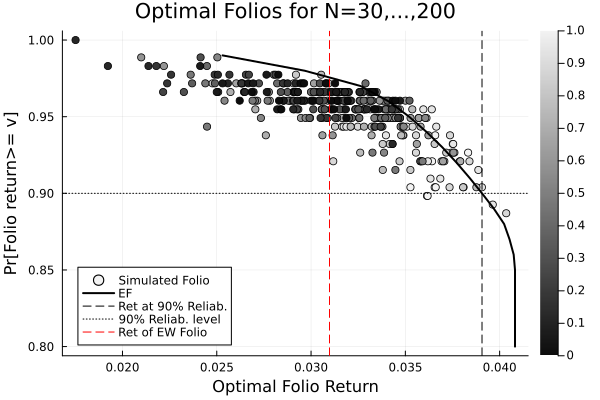

In [43]:
# Normalize the sample size to the range [0, 1] for color shading
normalized_sample_zise = (results.sample_size .- minimum(results.sample_size)) ./ (maximum(results.sample_size) - minimum(results.sample_size))

# Create the scatter plot of the saa solutions
scatter(
    results.mean_ret, results.prob,
    color = :grays,
    marker_z = 1 .- normalized_sample_zise,
    xlabel = "Optimal Folio Return",
    ylabel = "Pr[Folio return>= v]",
    title = "Optimal Folios for N=30,...,200",
    label = "Simulated Folio" 
)

# Add the e.f.
plot!(efficient_frontier.mean_ret, efficient_frontier.reliability, lw=2, color=:black, label="EF")

# Set reference values at the 90% reliability level
mean_ret_ref = efficient_frontier[efficient_frontier.reliability .== 0.9, :mean_ret]

# Add a dashed vertical line at the optimal folio return corresponding to alpha=0.1
vline!([mean_ret_ref], linestyle=:dash, color=:black, label = "Ret at 90% Reliab.")

# Add a dotted horizontal line at 90% relaiability level 
hline!([0.9], linestyle=:dot, color=:black, legend=false, label="90% Reliab. level")

# Add a dashed vertical line at the EW portfolio return 
vline!([ew_ret], linestyle=:dash, color=:red, label="Ret of EW Folio", legend = :bottomleft)


**I.2. Illustration for Lognormal Returns**: $\gamma=0$, $r\sim \text{Lognormal}(\bar{r},\Sigma)$, $\alpha = 0.10$ and $\beta = 0.01$

1. Estimate $\text{Pr}(r^T\hat{x}_N\geq v)$ with a MonteCarlo simulation 

2. Instead of the efficient frontier which cannot be computed for this distribution, plol the return upperbound frontier at reliabilty levels corresponding to $\alpha=0.02,\,\dots,0.20$.
3. Plot the optimal solutions $\hat{x}_N$ of the SAA as follows: on the horizontal axis optimal portfolio returns ($\bar{r}^T\hat{x}_N$)  vs. reliability ($\text{Pr}(r^T\hat{x}_N\geq v)$)  on the vertical.

**1. The continuously compounded returns are modeled as normal and are calibrated to the historical data. The obtained lognomral is that of the gross returns.**

In [22]:
cc_rets = log.(1 .+ rets[:, 2:n+1]);

# Compute the mean returns
cc_rets_stats = DataFrames.describe(cc_rets)
mean_cc_rets = cc_rets_stats[:, 1:2];


# Compute the covariance matrix
cov_matrix_cc_rets = cov(Matrix(cc_rets));

μ_lgn = Vector{Float64}(mean_cc_rets[!,2]);
Σ_lgn = cov_matrix_cc_rets;

# Instantiate the distribution    
dd = MvLogNormal(μ_lgn, Σ_lgn)

# Set the threshold folio return
v = -0.2;

# Collect relevant data for plotting the results
results = DataFrame(
            sample_size = Int64[],
            weights = Vector{Float64}[],
            mean_ret = Float64[],
            prob = Float64[]           
);

for N = 30:10:200
    for i=1:20
      w_opt, folio_opt_mean_ret, prob, saa_model = saa_zero_gamma_lognormal(r, dd, v, N, seed);
      push!(results, [N, w_opt, folio_opt_mean_ret, prob])
    end
end

**2. Compute the upper bound frontiers**

Find the upper bounds for $L=1,\, N = \left\lceil 1/\alpha \right\rceil$ and $B(L-1; \theta_N, M)\leq \beta$.

For $L=1$: $M\geq\frac{\ln\beta}{\ln(1-\theta_N)}$, where  $\theta_N:=B(\left\lfloor \gamma N \right\rfloor; \alpha, N)$, $\alpha=0.1$, $\beta = 0.01$, $\gamma=0$.  

In [23]:
α = 0.1
β = 0.01
γ = 0
N_f = ceil(Int, 1/α)
N_c = ceil(Int, 2/α)
L = 1
M_L_1 = compute_M(N_c, α, γ, β)

ef_L_1 = DataFrame(
                    reliab_level = Float64[],
                    nu = Float64[],
                    prob = Float64[],

        );

for α in 0.01:0.01:0.2
    ord_stats = DataFrame(
                    nu = Float64[],
                    prob = Float64[],
        );

    for i = 1:M_L_1 
          _, nu, p, _ = saa_zero_gamma_lognormal(r, dd, v, N_c, seed);
          push!(ord_stats, (nu, p))   
    end

    sorted = sort!(ord_stats, :nu, rev=true);
    nu, p = tuple(sorted[L, [:nu, :prob]]...)
    push!(ef_L_1, (1-α, nu, p))
end  

### For $M = 1000$ and $L$ the largest integer to yield $B(L-1; \theta_N, M)\leq \beta$:

In [26]:
M = 1000;
ef_f = compute_upper_bound_frontier(M, N_f, γ, β, dd, v);
ef_c = compute_upper_bound_frontier(M, N_c, γ, β, dd, v);

**3. Plot the Results**

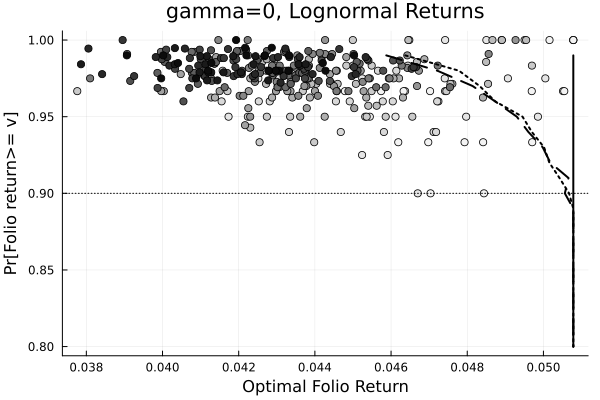

In [27]:
# Normalize the sample size to the range [0, 1] for color shading
normalized_sample_zise = (results.sample_size .- minimum(results.sample_size)) ./ (maximum(results.sample_size) - minimum(results.sample_size))

scatter(
    results.mean_ret, results.prob,
    color = :grays,
    marker_z = 1 .- normalized_sample_zise,
    xlabel = "Optimal Folio Return",
    ylabel = "Pr[Folio return>= v]",
    title = "gamma=0, Lognormal Returns",
    legend = false
    #ylim = (0, 1) 
)

# Add the upper bounds
plot!(ef_L_1.nu, ef_L_1.reliab_level, lw=2, color=:black)
plot!(ef_f.nu, ef_f.reliab_level, lw=2, linestyle=:dot, color=:black)
plot!(ef_c.nu, ef_c.reliab_level, lw=2, linestyle=:dash, color=:black)


# Add a dotted horizontal line at y = 0.9
hline!([0.9], linestyle=:dot, color=:black)

**II. For $\gamma>0$ the SAA problem can be shown to be equivalent to the mixed-integer linear program:**
$$
\displaystyle
\max_{\substack{x,z}}\{\bar{r}^Tx :  \mathbf{e}^Tx =1,\,\,z\in\{0,1\}^N,\,\, r_i^Tx+vz_i\geq v,\,\sum_{i=1}^{N}z_i\leq N\gamma,\,\, 1\leq i\leq N\}
$$

It is unclear how to choose $\gamma$ and $N$ in this case and numerical investigation should be performed with different values of both parameters (careful with large $N$!).


- For a choice $\gamma>\alpha$: if $\bar{x}$ is an optimal solution of the original problem (in the general formulation),
  $$\hat{p}_N(\bar{x})\leq\gamma\iff r_i^{\top}\bar{x}\leq v \text{ no more than }\gamma N \text{ times in the }N \text{ trials}.$$
  
 Note that $p(\bar{x}) = \mathbb{P}[r^{\top}\bar{x}\leq v]$, and let $k = \lfloor\gamma N\rfloor$ and $p=p(\bar{x})$. It follows that:
$$
\text{Pr}(\hat{p}_N(\bar{x})\leq \gamma) = B(k; p, N)\geq 1-exp\left[-\frac{N}{2p}\left(\frac{k}{N}-p\right)^2\right]\hspace{.5cm} \text{(Chernoff inequality)}
$$
Since $p\leq\alpha$ and $\gamma>\alpha$, it can be concluded that:
$$
\text{Pr}(\hat{p}_N(\bar{x})\leq \gamma)\to 1 \text{ at a rate of } e^{-\kappa N} \text{ where 
}\kappa=\frac{(\gamma-\alpha)^2}{2\alpha}
$$

- For a choice $\gamma <\alpha$: if $p(\bar{x})=\alpha$, then $\text{Pr}(\hat{p}_N(\bar{x})\leq \gamma)\to 0$ exponentially fast.


**II.1. Illustration for $\gamma = 0.05 $ and normal returns**

**1. Run 20 replications of the corresponding mixed integer linear program for each of the sample sizes $N=20,\, 40,\dots,\,400$**


In [28]:
v = -0.05; # A lower bound threshold on the folio's return
r = Matrix{Float64}(rets[!, 2:n+1]); # The asset monthly returns matrix
γ = 0.05;

# Instantiate the distribution of the returns
d = MvNormal(μ, Σ)

# Collect relevant data for plotting the results
results = DataFrame(
            sample_size = Int64[],
            mean_ret = Float64[],
            prob = Float64[]           
);

for N = 30:10:200
    for i=1:20
      w_opt, folio_opt_mean_ret, prob, saa_model = saa_positive_gamma_normal(r, d, v, γ, N, seed);
      push!(results, [N, folio_opt_mean_ret, prob])
    end
end

**2. Plot the results**

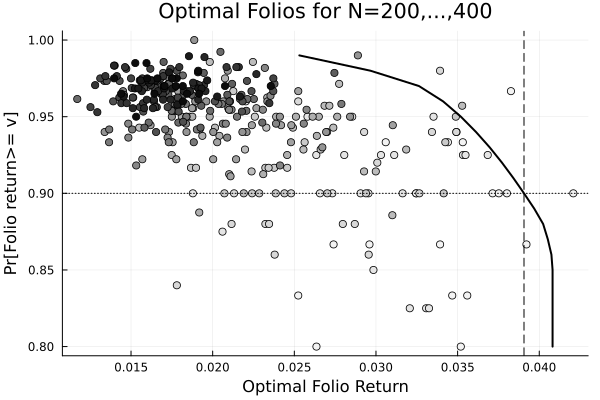

In [29]:
# Normalize the sample size to the range [0, 1] for color shading
normalized_sample_size = (results.sample_size .- minimum(results.sample_size)) ./ (maximum(results.sample_size) - minimum(results.sample_size))

scatter(
    results.mean_ret, results.prob,
    color = :grays,
    marker_z = 1 .- normalized_sample_size,
    xlabel = "Optimal Folio Return",
    ylabel = "Pr[Folio return>= v]",
    title = "Optimal Folios for N=200,...,400",
    legend = false
    #ylim = (0, 1) 
)


plot!(efficient_frontier.mean_ret, efficient_frontier.reliability, lw=2, color=:black)

#set reference values at the 90% reliability level
mean_ret_ref = efficient_frontier[efficient_frontier.reliability .== 0.9, :mean_ret]

# Add a dashed vertical line at the optimal folio return corresponding to alpha=0.1
vline!([mean_ret_ref], linestyle=:dash, color=:black)

# Add a dotted horizontal line at 90% relaiability level 
hline!([0.9], linestyle=:dot, color=:black)

**II.2. Illustration for  $\gamma=0.05$ and Lognormal Returns**

In [32]:
dd = MvLogNormal(μ_lgn, Σ_lgn)
γ = 0.05;

# Set the threshold folio return
v = -0.25;

# Collect relevant data for plotting the results
results = DataFrame(
            sample_size = Int64[],
            weights = Vector{Float64}[],
            mean_ret = Float64[],
            prob = Float64[]           
);

for N = 30:10:200
    for i=1:20
      w_opt, folio_opt_mean_ret, prob, saa_model = saa_positive_gamma_lognormal(r, dd, v, γ, N, seed);
      push!(results, [N, w_opt, folio_opt_mean_ret, prob])
    end
end

ef_c = compute_upper_bound_frontier(M, N_f, γ, β, dd, v);

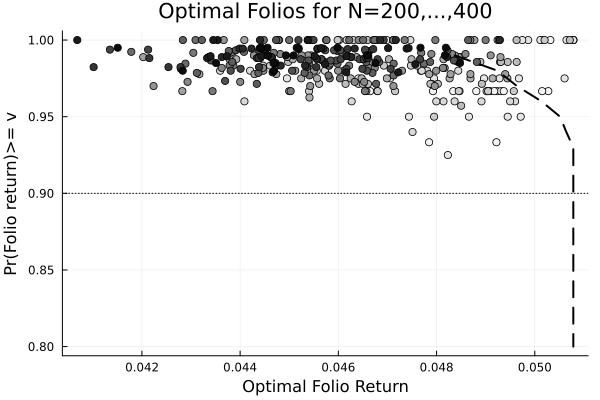

In [31]:
# Create the scatter plot

# Normalize the sample size to the range [0, 1] for color shading
normalized_sample_size = (results.sample_size .- minimum(results.sample_size)) ./ (maximum(results.sample_size) - minimum(results.sample_size))

scatter(
    results.mean_ret, results.prob,
    color = :grays,
    marker_z = 1 .- normalized_sample_size,
    xlabel = "Optimal Folio Return",
    ylabel = "Pr(Folio return)>= v",
    title = "Optimal Folios for N=200,...,400",
    legend = false
    #ylim = (0, 1) 
)

plot!(ef_c.nu, ef_c.reliab_level, lw=2, linestyle=:dash, color=:black)

# Add a dotted horizontal line at y = 0.9
hline!([0.9], linestyle=:dot, color=:black)